Epoch [10/80], Train Loss: 0.6584, Val Loss: 0.6555
Epoch [20/80], Train Loss: 0.5282, Val Loss: 0.5231
Epoch [30/80], Train Loss: 0.4149, Val Loss: 0.4059
Epoch [40/80], Train Loss: 0.3725, Val Loss: 0.3576
Epoch [50/80], Train Loss: 0.3569, Val Loss: 0.3284
Epoch [60/80], Train Loss: 0.3452, Val Loss: 0.3152
Epoch [70/80], Train Loss: 0.3319, Val Loss: 0.3090
Epoch [80/80], Train Loss: 0.3261, Val Loss: 0.3086

Test Accuracy: 0.7692


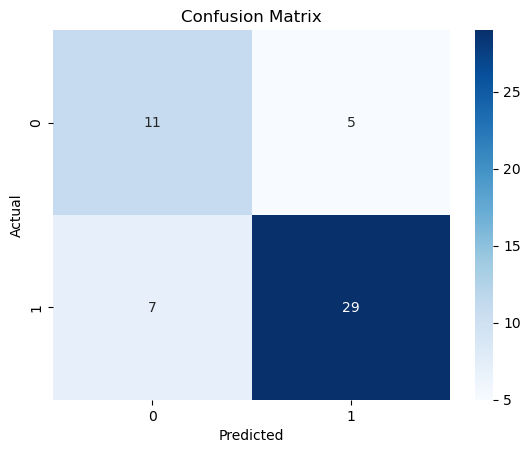


Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.69      0.65        16
         1.0       0.85      0.81      0.83        36

    accuracy                           0.77        52
   macro avg       0.73      0.75      0.74        52
weighted avg       0.78      0.77      0.77        52



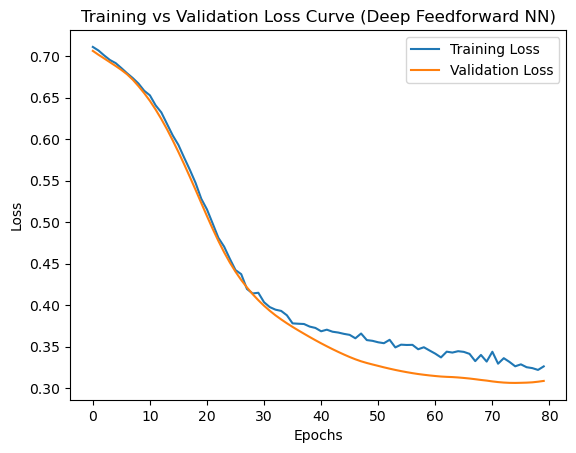

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("WesternFoodDataset_Relabeled.csv")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, stratify=y_train, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class DeepHeartNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepHeartNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = DeepHeartNN(X_train.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 80
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_test_pred = torch.sigmoid(model(X_test))
    y_pred_class = (y_test_pred > 0.5).float()

acc = accuracy_score(y_test, y_pred_class)
print(f"\nTest Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve (Deep Feedforward NN)")
plt.legend()
plt.show()